[View in Colaboratory](https://colab.research.google.com/github/JoaoAreias/Control-theory/blob/master/M%C3%A9todo_de_Sundaresan.ipynb)

# Método de Sundaresan

Neste notebook implementamos o método de Sundaressan para identificar o sistema que rege a tensão no capacitor de um circuito RLC.  Primeiro cuidamos das dependências e carregamos os dados:

In [0]:
# Computação científica
%matplotlib inline
from scipy import signal
from scipy.optimize import newton
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# PyDrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticação
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Lendo dados
subamortecido_id = '1vWbRdgLBX3H2LV56KpihTNlCfqWFrsVx'
superamortecido_id = '1QxVwz9wFBwN0gpaXRzO4RjCMcSUC7ng4'

drive.CreateFile({'id': subamortecido_id}).GetContentFile('Simulacao_subamortecido.CSV')
drive.CreateFile({'id': superamortecido_id}).GetContentFile('Simulacao_supermortecido.CSV')

subamortecido = pd.read_csv('Simulacao_subamortecido.CSV', encoding="ISO-8859-1", sep=';')
superamortecido = pd.read_csv('Simulacao_supermortecido.CSV', encoding="ISO-8859-1", sep=';')

In [3]:
subamortecido.head()

,Tempo Vc,Tensão Vc,Tempo ref,Tensão ref
0,0,0,0,0
1,1E-11,1E-17,1E-11,"0,01"
2,"1,084E-11","1,09165E-17","1,084E-11","0,01084"
3,"1,252E-11","1,29143E-17","1,252E-11","0,01252"
4,"1,588E-11","1,80411E-17","1,588E-11","0,01588"


In [4]:
superamortecido.head()

,Tempo Vc,Tensão Vc,Unnamed: 2,Tempo ref,Tensão referência
0,0,0,NaN,0,0
1,1E-11,"9,99999E-18",NaN,1E-11,"0,01"
2,"1,084E-11","1,09165E-17",NaN,"1,084E-11","0,010840001"
3,"1,252E-11","1,29143E-17",NaN,"1,252E-11","0,012520002"
4,"1,588E-11","1,80411E-17",NaN,"1,588E-11","0,015880004"


Como a simulação foi salva pelo Excel em um formato diferente do padrâo americano, algumas converções são necessárias. Além disso excluimos a coluna extra do sistema superamortecido e padronizamos os nomes.

In [5]:
for column in subamortecido.columns:
  subamortecido[column] = subamortecido[column].str.replace(',', '.')
  subamortecido[column] = subamortecido[column].str.replace('E', 'e')
  subamortecido[column] = pd.to_numeric(subamortecido[column])

subamortecido.head()

,Tempo Vc,Tensão Vc,Tempo ref,Tensão ref
0,0.000000e+00,0.000000e+00,0.000000e+00,0.00000
1,1.000000e-11,1.000000e-17,1.000000e-11,0.01000
2,1.084000e-11,1.091650e-17,1.084000e-11,0.01084
3,1.252000e-11,1.291430e-17,1.252000e-11,0.01252
4,1.588000e-11,1.804110e-17,1.588000e-11,0.01588


In [6]:
superamortecido.rename({'Tensão referência': 'Tensão ref'}, inplace=True,  axis='columns')
superamortecido.drop(['Unnamed: 2'], inplace=True, axis=1)

for column in superamortecido.columns:
  superamortecido[column] = superamortecido[column].str.replace(',', '.')
  superamortecido[column] = superamortecido[column].str.replace('E', 'e')
  superamortecido[column] = pd.to_numeric(superamortecido[column])

superamortecido.head()

,Tempo Vc,Tensão Vc,Tempo ref,Tensão ref
0,0.000000e+00,0.000000e+00,0.000000e+00,0.00000
1,1.000000e-11,9.999990e-18,1.000000e-11,0.01000
2,1.084000e-11,1.091650e-17,1.084000e-11,0.01084
3,1.252000e-11,1.291430e-17,1.252000e-11,0.01252
4,1.588000e-11,1.804110e-17,1.588000e-11,0.01588


### Gráficos

Primeiro vemos como estes sistemas se comportam no tempo

In [0]:
# Helper function
def plot(df):
  fig, ax1 = plt.subplots(figsize=(20, 8))
  
  color = 'tab:blue'
  ax1.set_xlabel('Tempo (s)')
  ax1.set_ylabel('Tensão (V)')
  ax1.plot(df['Tempo ref'], df['Tensão ref'], color=color, label='Entrada')
  ax1.tick_params(axis='y', labelcolor=color)
  color = 'tab:green'
  ax1.plot(df['Tempo ref'], df['Tensão Vc'], color=color, label='Saída')
  
  plt.legend()
  plt.show();
  

#### Sistema subamortecido

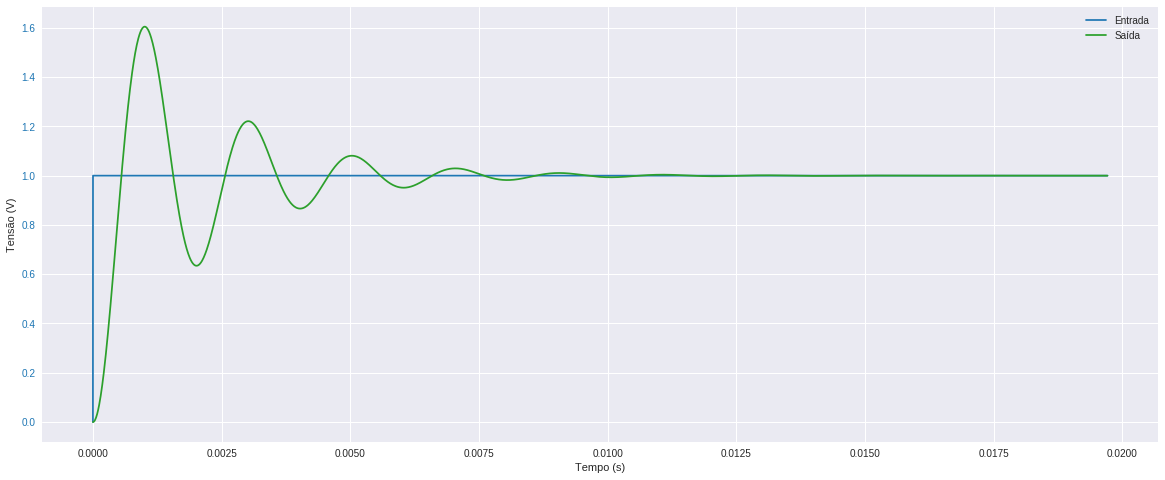

In [8]:
plot(subamortecido[0:2000])

Para simplificar o código vamos usar apenas o intervalo dos dados apresentados no gráfico

In [0]:
subamortecido = subamortecido[0:2000]

#### Sistema super amortecido

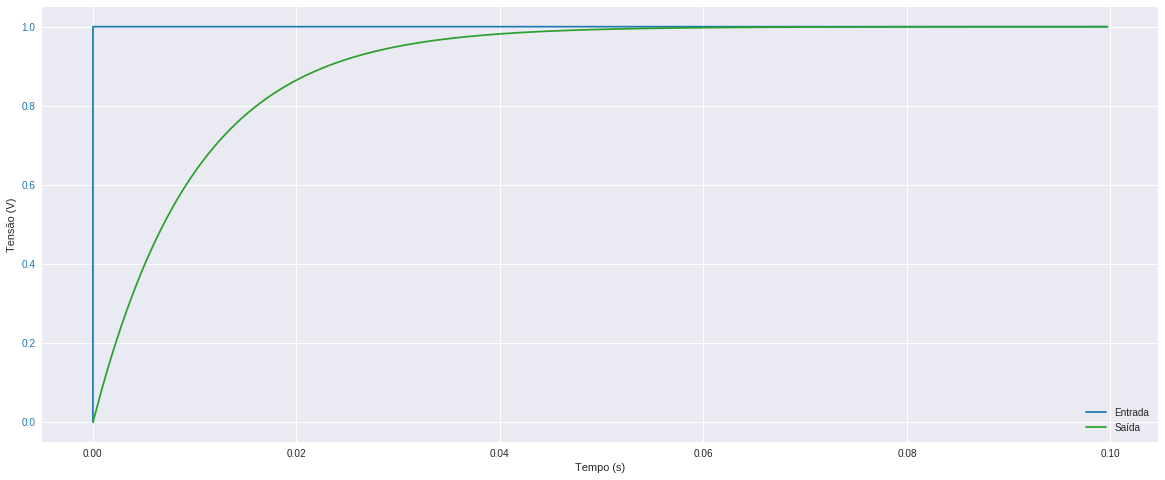

In [10]:
plot(superamortecido[0:10000])

Similarmente ao caso do sistema subamortecido vamos apenas usar o intervalo apresentado no gráfico

In [0]:
superamortecido = superamortecido[0:10000]

### Método para o caso superamortecido

O método consiste em aplicar  os seguintes passos para identificar o sistema:

- Ache o ganho em regime permanente;
- Remova o valor da condição inicial e normalize os dados;
- Determinar a area sombreada entre o gráfico e o impulso ($m_1$);
- Determinar a inclinação da tangente no ponto de inflexão ($M_i$);
- Determinar $t_m$ que é a interceção da tangente com o valor do regime permanente;
- Determinar $\lambda$ a partir de $\lambda = (t_m - m_1)M_i$;
- Determinar $\eta$ a partir das equações (1) e (2)

$$
\lambda = X e^{-X} \tag{1}
$$

$$
X = \frac{\ln \eta}{\eta - 1} \tag{2}
$$

- Finalmente determinar $\tau_1, \tau_2, \tau_d$ a partir das equações  (3), (4) e (5)

$$
\tau_1 = \frac{\eta^{\frac{\eta}{1-\eta}}}{M_i} \tag{3}
$$

$$
\tau_2 = \frac{\eta^{\frac{1}{1-\eta}}}{M_i} \tag{4}
$$

$$
\tau_d = m_1 - \tau_1 - \tau_2 \tag{5}
$$



In [0]:
def sundaresan_super(df):
  '''
    1) Começamos achando o ganho em regime permanente:
    
  Para descobrir se o sistema  esta em regime permanete
  primeiro olhamos se ele é igual aos valores anteriores
  '''
  steady_state_indexing = (
      (df['Tensão Vc'].rolling(10).std() < 1e-5) &
      (df['Tensão Vc'].rolling(10).mean() > 0.5)
  )
  ganho = df[steady_state_indexing]['Tensão Vc'].mean()
  print(f"Ganho: {ganho}")
  
  '''
    2) Normalização dos dados
  '''
  df['Tensão Vc'] = df['Tensão Vc']/ganho
  
  '''
    3) Calcular m1 como a área entre o gráfico
  e o impulso
  '''
  m1 = np.trapz(
      y = df['Tensão ref'] - df['Tensão Vc'],
      x = df['Tempo ref'] 
  )
  print(f"m1: {m1}")
  
  '''
    4) Determinar a inclinação da tangente no
  ponto de inflexão
  '''
  diff_data = df['Tensão Vc'].diff()/df['Tempo Vc'].diff()
  diff_data.fillna(0, inplace=True)
  inflection_point = df.iloc[np.argmax(diff_data.values)]
  Mi = np.amax(diff_data.values)
  print(f"Mi: {Mi}")
  
  
  '''
    5) Determinar tm
  '''
  tm = np.roots([
    Mi, 
    inflection_point["Tensão Vc"] - Mi*inflection_point["Tempo Vc"] - 1
  ])[0]
  print(f"tm: {tm}")
  
  
  '''
    6) Determinar lambda
  '''
  l = (tm - m1)*Mi
  print(f'Lambda: {l}')
  
  '''
    7) Determinar eta
  '''
  eta = newton(lambda eta: np.log(eta)/(eta-1) - l, 0.1)
  print(f'Eta: {eta}')
  
  '''
    Gráfico de tm e ponto de inflexão
  '''
  y = np.poly1d([
    Mi, 
    inflection_point["Tensão Vc"] - Mi*inflection_point["Tempo Vc"]
  ])
  
  color = 'tab:blue'
  fig, ax1 = plt.subplots(figsize=(20, 8))
  ax1.set_xlabel('Tempo (s)')
  ax1.set_ylabel('Tensão (V)')
  ax1.plot(df['Tempo ref'], df['Tensão ref'], color=color, label='Entrada')
  ax1.tick_params(axis='y', labelcolor=color)
  color = 'tab:green'
  ax1.plot(df['Tempo ref'], df['Tensão Vc'], color=color, label='Saída')
  ax1.plot(inflection_point['Tempo ref'], inflection_point['Tensão Vc'], 'ro', label='Ponto de inflexão',)
  ax1.plot(df['Tempo Vc'][0:df.shape[0]//9], y(df['Tempo Vc'][0:df.shape[0]//9].values), 'r--')
  ax1.plot(tm, y(tm), 'go', label='Tm')
  
  plt.legend()
  plt.show();
  
  
  ''' Por fim podemos retornar o sistema:
  
       e^{-td*s}                 e^{-td*s}
  --------------------  = ------------------------
  (t1*s + 1)(t2*s + 1)    t1*t2*s + (t1 + t2)s + 1
  
  As bibliotecas de controle entretanto não oferecem
  uma forma de implementar o atraso no tempo representado
  por e^{-td*s} então retornaremos o sistema sem o
  atraso.
  '''
  t1 = (eta**(eta /(1-eta)))/Mi
  t2 = (eta**(1 /(1-eta)))/Mi
  
  return signal.TransferFunction([1], [t1*t2, t1+t2, 1])

Primeiro usamos o método para descobrir o sistema

Ganho: 1.0000005933786504
m1: 0.00993135554341843
Mi: 99.52058020981984
tm: 0.01005796890169618
Lambda: 0.012600634878115535
Eta: 493.09428427448506


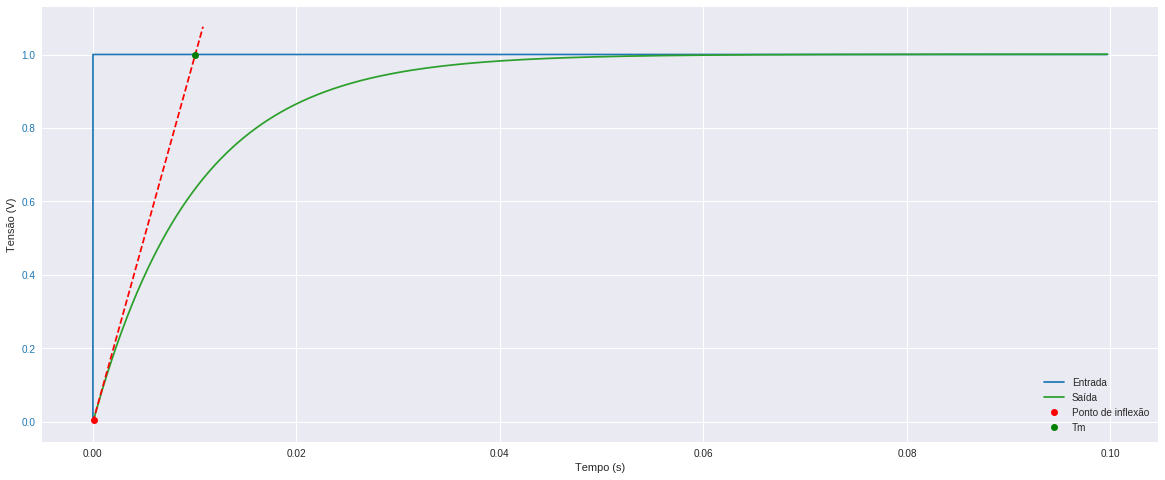

In [15]:
sys = sundaresan_super(superamortecido)

Agora podemos ver como estes dados se relacionam com a saída real

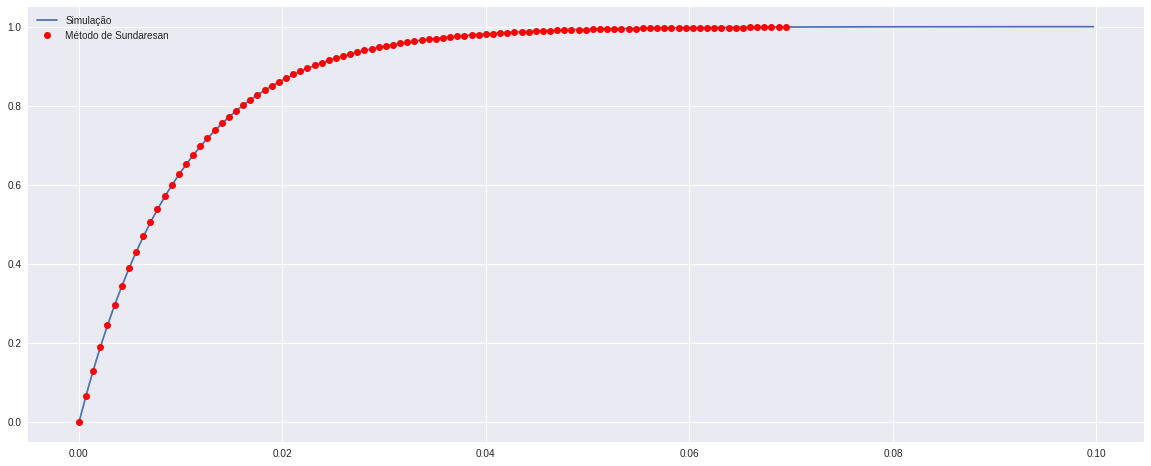

In [16]:
t, y = signal.step(sys)

plt.figure(figsize=(20, 8))
plt.plot(superamortecido['Tempo Vc'], superamortecido['Tensão Vc'], label='Simulação')
plt.plot(t, y, 'ro', label='Método de Sundaresan')

plt.legend()
plt.show();

### Método para o caso sub-amortecido

Para o caso sub-amortecido o método é similar ao método para o caso superamortecido, mudando apenas  para os ultimos passos assim, para a maior parte do método, o código será o mesmo. O método consiste em:


- Ache o ganho em regime permanente;
- Remova o valor da condição inicial e normalize os dados;
- Determinar a area sombreada entre o gráfico e o impulso ($m_1$);
- Determinar a inclinação da tangente no ponto de inflexão ($M_i$);
- Determinar $t_m$ que é a interceção da tangente com o valor do regime permanente;
- Determinar $\lambda$ a partir de $\lambda = (t_m - m_1)M_i$;
- Determinar $\zeta$ a partir das equaçãos (6)

$$
\lambda = \frac{\cos^{-1}\zeta}{\sqrt{1-\zeta^2}} e ^{\frac{-\zeta\cos^{-1}\zeta}{\sqrt{1-\zeta^2}}} \tag{6}
$$

- Finalmente determinar $\tau_d$ e $\omega_n$ a partir das equações  (7) e (8)

$$
\omega_d = \frac{\cos^{-1}\zeta}{\sqrt{1-\zeta^2}}\frac{1}{t_m - m_1} \tag{7}
$$

$$
\tau_d = m_1 - \frac{2\zeta}{\omega_n} \tag{8}
$$

In [0]:
def sundaresan_sub(df):
  '''
    1) Começamos achando o ganho em regime permanente:
    
  Para descobrir se o sistema  esta em regime permanete
  primeiro olhamos se ele é igual aos valores anteriores
  '''
  steady_state_indexing = (
      (df['Tensão Vc'].rolling(10).std() < 1e-5) &
      (df['Tensão Vc'].rolling(10).mean() > 0.5)
  )
  ganho = df[steady_state_indexing]['Tensão Vc'].mean()
  print(f"Ganho: {ganho}")
  
  '''
    2) Normalização dos dados
  '''
  df['Tensão Vc'] = df['Tensão Vc']/ganho
  
  '''
    3) Calcular m1 como a área entre o gráfico
  e o impulso
  '''
  m1 = np.trapz(
      y = df['Tensão ref'] - df['Tensão Vc'],
      x = df['Tempo ref'] 
  )
  print(f"m1: {m1}")
  
  '''
    4) Determinar a inclinação da tangente no
  ponto de inflexão
  '''
  diff_data = df['Tensão Vc'].diff()/df['Tempo Vc'].diff()
  diff_data.fillna(0, inplace=True)
  inflection_point = df.iloc[np.argmax(diff_data.values)]
  Mi = np.amax(diff_data.values)
  print(f"Mi: {Mi}")
  
  
  '''
    5) Determinar tm
  '''
  tm = np.roots([
    Mi, 
    inflection_point["Tensão Vc"] - Mi*inflection_point["Tempo Vc"] - 1
  ])[0]
  print(f"tm: {tm}")
  
  
  '''
    6) Determinar lambda
  '''
  l = (tm - m1)*Mi
  print(f'Lambda: {l}')
  
  '''
    7) Determinar zeta
  '''
  zeta = newton(
      lambda zeta: (np.arccos(zeta)/(np.sqrt(1-zeta**2)))*np.exp(-zeta*np.arccos(zeta)/(np.sqrt(1-zeta**2))) - l,
      0.1
  )
  
  '''
    8) Determinar wn e td
  '''
  wn = (np.arccos(zeta)/(np.sqrt(1-zeta**2)))*(1/(tm-m1))
  td = m1 - 2*zeta/wn
  
  '''
    Gráfico de tm e ponto de inflexão
  '''
  y = np.poly1d([
    Mi, 
    inflection_point["Tensão Vc"] - Mi*inflection_point["Tempo Vc"]
  ])
  
  color = 'tab:blue'
  fig, ax1 = plt.subplots(figsize=(20, 8))
  ax1.set_xlabel('Tempo (s)')
  ax1.set_ylabel('Tensão (V)')
  ax1.plot(df['Tempo ref'], df['Tensão ref'], color=color, label='Entrada')
  ax1.tick_params(axis='y', labelcolor=color)
  color = 'tab:green'
  ax1.plot(df['Tempo ref'], df['Tensão Vc'], color=color, label='Saída')
  ax1.plot(inflection_point['Tempo ref'], inflection_point['Tensão Vc'], 'ro', label='Ponto de inflexão',)
  ax1.plot(df['Tempo Vc'][0:df.shape[0]//15], y(df['Tempo Vc'][0:df.shape[0]//15].values), 'r--')
  ax1.plot(tm, y(tm), 'go', label='Tm')
  
  plt.legend()
  plt.show();
  
  
  ''' Por fim podemos retornar o sistema:
  
       e^{-td*s}*wn^2
  --------------------------
   s^2 + 2*wn*zeta*s + wn^2
  
  As bibliotecas de controle entretanto não oferecem
  uma forma de implementar o atraso no tempo representado
  por e^{-td*s} então retornaremos o sistema sem o
  atraso.
  '''
  
  return signal.TransferFunction([wn**2], [1, 2*wn*zeta, wn**2])

Primeiro usamos o método para descobrir o sistema

Ganho: 1.000008247363296
m1: 0.00010014471823409595
Mi: 2521.899100981924
tm: 0.0005522645180902832
Lambda: 1.1402005167934464


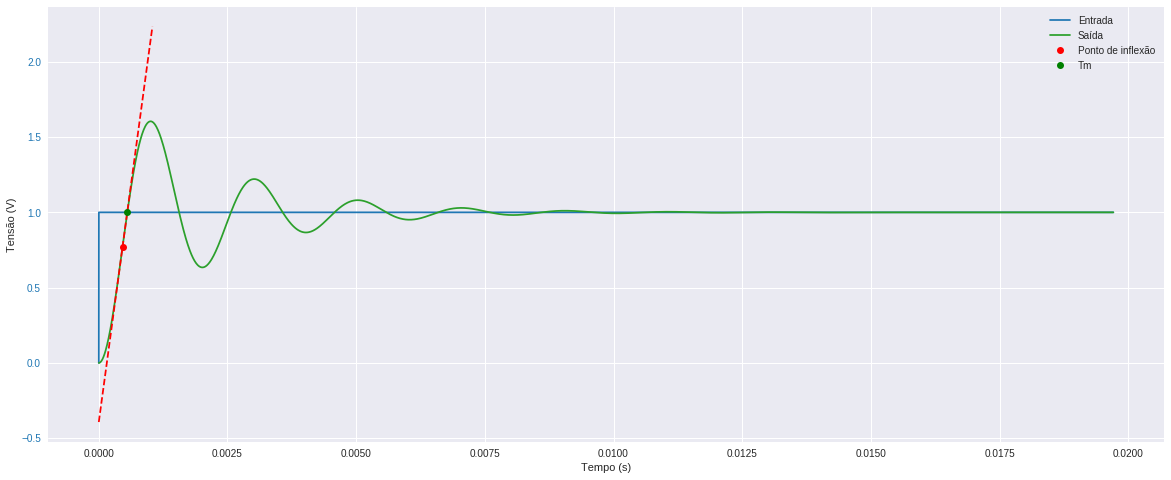

In [18]:
sys = sundaresan_sub(subamortecido)

Agora podemos ver como estes dados se relacionam com a saída real

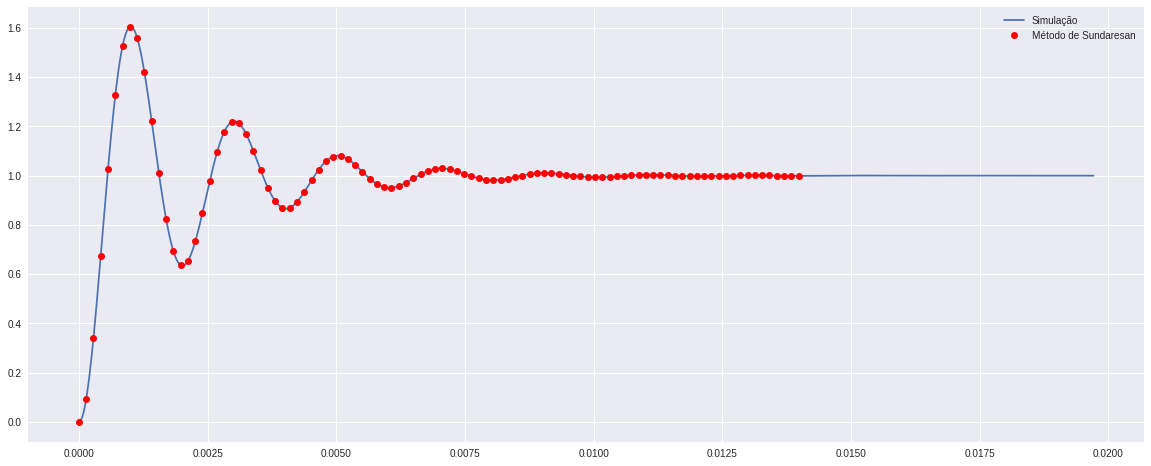

In [19]:
t, y = signal.step(sys)

plt.figure(figsize=(20, 8))
plt.plot(subamortecido['Tempo Vc'], subamortecido['Tensão Vc'], label='Simulação')
plt.plot(t, y, 'ro', label='Método de Sundaresan')

plt.legend()
plt.show();